## Import Necessary Libraries

In [295]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import itertools
import random
import PIL
from PIL import Image
import io

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, \
GlobalAveragePooling2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras import models, layers 
from keras_preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import  Adam

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

## Load the Files of Images

In [296]:
datagen = ImageDataGenerator()

In [297]:
no_aug_train_path =  './data/fruits-360_dataset/fruits-360_2/Training'
no_aug_test_path = './data/fruits-360_dataset/fruits-360_2/Test'
no_aug_val_path = './data/fruits-360_dataset/fruits-360_2/Validation'

aug_train_path =  './data/fruits-360_dataset/fruits-360/Training'
aug_test_path = './data/fruits-360_dataset/fruits-360/Test'
aug_val_path = './data/fruits-360_dataset/fruits-360/Validation'

In [298]:
baseline_train_datagen = ImageDataGenerator(rescale = 1./255)
baseline_test_datagen = ImageDataGenerator(rescale = 1./255)
baseline_val_datagen = ImageDataGenerator(rescale = 1./255)

In [299]:
baseline_image_size = (100, 100)
baseline_train_generator = baseline_train_datagen.flow_from_directory(
    no_aug_train_path,
    target_size = baseline_image_size,
    batch_size = 2563,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

baseline_test_generator = baseline_test_datagen.flow_from_directory(
    no_aug_test_path,
    target_size = baseline_image_size,
    batch_size = 954,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

baseline_val_generator = baseline_val_datagen.flow_from_directory(
    no_aug_val_path,
    target_size = baseline_image_size,
    batch_size = 285,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [300]:
train_class_names = list(baseline_train_generator.class_indices.keys())
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [301]:
test_class_names = list(baseline_test_generator.class_indices.keys())
test_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [302]:
val_class_names = list(baseline_val_generator.class_indices.keys())
val_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

## Begin Modeling

#### Baseline Model

In [303]:
# create the data sets
baseline_train_images, baseline_train_labels = next(baseline_train_generator)
baseline_test_images, baseline_test_labels = next(baseline_test_generator)
baseline_val_images, baseline_val_labels = next(baseline_val_generator)

In [304]:
baseline_train_img = baseline_train_images.reshape(baseline_train_images.shape[0], -1)
baseline_test_img = baseline_test_images.reshape(baseline_test_images.shape[0], -1)
baseline_val_img = baseline_val_images.reshape(baseline_val_images.shape[0], -1)

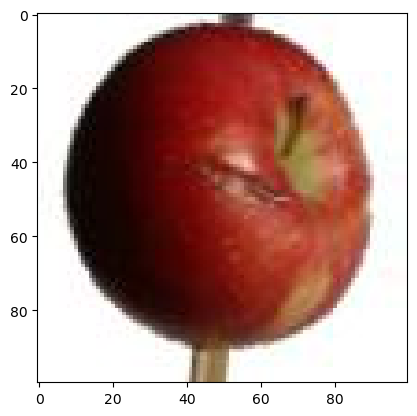

In [305]:
chosen_image = random.choice(os.listdir('./data/fruits-360_dataset/fruits-360/Training/Apple Braeburn/'))
image_path = './data/fruits-360_dataset/fruits-360/Training/Apple Braeburn/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [306]:
opt = Adam(learning_rate=0.0002)
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(6))

np.random.seed(3)
baseline_model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

baseline_model_histoire = baseline_model.fit(baseline_train_img,
                                       baseline_train_labels,
                                       epochs = 10,
                                       batch_size = 80,
                                       validation_data = (baseline_val_img, baseline_val_labels))

Epoch 1/10
 5/33 [===>..........................] - ETA: 0s - loss: 3.5020 - accuracy: 0.1950

2022-12-09 00:06:43.353658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 17ms/step - loss: 6.6983 - accuracy: 0.3402 - val_loss: 8.3290 - val_accuracy: 0.4175
Epoch 2/10
 7/33 [=====>........................] - ETA: 0s - loss: 8.1747 - accuracy: 0.4143

2022-12-09 00:06:43.910343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 10ms/step - loss: 8.0756 - accuracy: 0.3742 - val_loss: 10.6888 - val_accuracy: 0.2982
Epoch 3/10
33/33 [==============================] - 0s 8ms/step - loss: 11.5147 - accuracy: 0.3004 - val_loss: 8.9922 - val_accuracy: 0.2842
Epoch 4/10
33/33 [==============================] - 0s 8ms/step - loss: 8.8357 - accuracy: 0.2961 - val_loss: 8.5963 - val_accuracy: 0.2842
Epoch 5/10
33/33 [==============================] - 0s 9ms/step - loss: 8.7099 - accuracy: 0.2957 - val_loss: 8.5963 - val_accuracy: 0.2842
Epoch 6/10
33/33 [==============================] - 0s 8ms/step - loss: 8.7099 - accuracy: 0.2957 - val_loss: 8.5963 - val_accuracy: 0.2842
Epoch 7/10
33/33 [==============================] - 0s 8ms/step - loss: 8.7099 - accuracy: 0.2957 - val_loss: 8.5963 - val_accuracy: 0.2842
Epoch 8/10
33/33 [==============================] - 0s 8ms/step - loss: 8.7099 - accuracy: 0.2957 - val_loss: 8.5963 - val_accuracy: 0.2842
Epoch 9/10
33/33 [==========

In [307]:
baseline_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 6)                 180006    
                                                                 
Total params: 180,006
Trainable params: 180,006
Non-trainable params: 0
_________________________________________________________________


In [308]:
baseline_model_results_train = baseline_model.evaluate(baseline_train_img, baseline_train_labels)
baseline_model_results_test = baseline_model.evaluate(baseline_test_img, baseline_test_labels)

30/30 [==============================] - 0s 6ms/step - loss: 9.5627 - accuracy: 0.2201


#### Baseline Model Visualizations

#### Graphing Accuracy and Loss Metrics

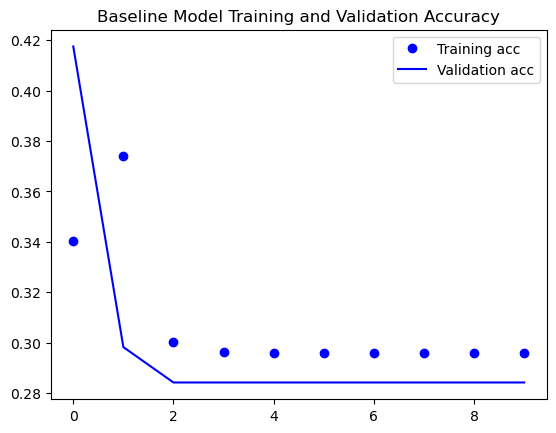

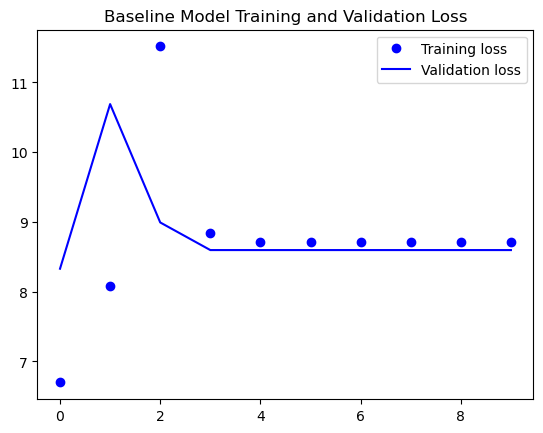

In [309]:
# Plot history
baseline_model_acc = baseline_model_histoire.history['accuracy']
baseline_model_val_acc = baseline_model_histoire.history['val_accuracy']
baseline_model_loss = baseline_model_histoire.history['loss']
baseline_model_val_loss = baseline_model_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_acc))

plt.plot(baseline_model_epochs, baseline_model_acc, 'bo', label = 'Training acc')
plt.plot(baseline_model_epochs, baseline_model_val_acc, 'b', label = 'Validation acc')
plt.title('Baseline Model Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();



#### Confusion Matrix

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-09 00:06:47.613116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


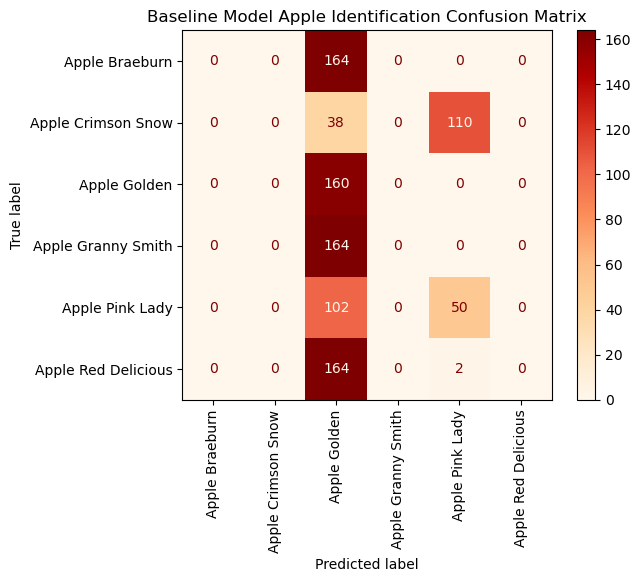

In [310]:
class_names = train_class_names
class estimator:
    _estimator_type = ''
    classes_= []
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob = self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)

        return y_pred

classifier = estimator(baseline_model, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = baseline_test_img, 
                      y_true = np.argmax(baseline_test_labels, axis = -1),
                      display_labels = class_names,
                      xticks_rotation = 'vertical',
                     cmap='OrRd');
plt.title('Baseline Model Apple Identification Confusion Matrix')
plt.show()

#### Model 2

In [311]:
model_2_train_datagen = ImageDataGenerator(rescale = 1./255)
model_2_test_datagen = ImageDataGenerator(rescale = 1./255)
model_2_val_datagen = ImageDataGenerator(rescale = 1./255)

In [312]:
model_2_image_size = (100, 100)
model_2_train_generator = model_2_train_datagen.flow_from_directory(
    aug_train_path,
    target_size = model_2_image_size,
    batch_size = 7841,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_2_test_generator = model_2_test_datagen.flow_from_directory(
    aug_test_path,
    target_size = model_2_image_size,
    batch_size = 3017,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_2_val_generator = model_2_val_datagen.flow_from_directory(
    aug_val_path,
    target_size = model_2_image_size,
    batch_size = 1207,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

Found 7841 images belonging to 6 classes.
Found 3017 images belonging to 6 classes.
Found 1207 images belonging to 6 classes.


In [313]:
# create the data sets
model_2_train_images, model_2_train_labels = next(model_2_train_generator)
model_2_test_images, model_2_test_labels = next(model_2_test_generator)
model_2_val_images, model_2_val_labels = next(model_2_val_generator)

In [314]:
model_2_train_img = model_2_train_images.reshape(model_2_train_images.shape[0], -1)
model_2_test_img = model_2_test_images.reshape(model_2_test_images.shape[0], -1)
model_2_val_img = model_2_val_images.reshape(model_2_val_images.shape[0], -1)

In [315]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
#model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(6, activation = 'softmax'))

In [316]:
model_2_train_images.shape

(7841, 100, 100, 3)

In [317]:
model_2_train_img.shape

(7841, 30000)

In [318]:
model_2_train_labels.shape

(7841, 6)

In [319]:
model_2_val_img.shape

(1207, 30000)

In [320]:
model_2_val_labels.shape

(1207, 6)

In [321]:
opt = Adam(learning_rate=0.0001)

np.random.seed(42)
model_2.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model_2_histoire = model_2.fit(model_2_train_images,
                               model_2_train_labels,
                               epochs = 25,
                               batch_size = 200,
                               validation_data = (model_2_val_images, model_2_val_labels))

Epoch 1/25


2022-12-09 00:06:52.858696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 1.1662 - accuracy: 0.5555

2022-12-09 00:06:54.811193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 50ms/step - loss: 1.1662 - accuracy: 0.5555 - val_loss: 0.8987 - val_accuracy: 0.6935
Epoch 2/25
40/40 [==============================] - 2s 39ms/step - loss: 0.4626 - accuracy: 0.8739 - val_loss: 0.7250 - val_accuracy: 0.7896
Epoch 3/25
40/40 [==============================] - 2s 39ms/step - loss: 0.2441 - accuracy: 0.9482 - val_loss: 0.7387 - val_accuracy: 0.7978
Epoch 4/25
40/40 [==============================] - 2s 39ms/step - loss: 0.1560 - accuracy: 0.9670 - val_loss: 0.8295 - val_accuracy: 0.8111
Epoch 5/25
40/40 [==============================] - 2s 38ms/step - loss: 0.1060 - accuracy: 0.9767 - val_loss: 0.7672 - val_accuracy: 0.8202
Epoch 6/25
40/40 [==============================] - 2s 38ms/step - loss: 0.0798 - accuracy: 0.9832 - val_loss: 0.7589 - val_accuracy: 0.8293
Epoch 7/25
40/40 [==============================] - 2s 38ms/step - loss: 0.0602 - accuracy: 0.9881 - val_loss: 0.8069 - val_accuracy: 0.8318
Epoch 8/25
40/40 [======

In [322]:
model_2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 18)        504       
                                                                 
 flatten_13 (Flatten)        (None, 172872)            0         
                                                                 
 dense_34 (Dense)            (None, 6)                 1037238   
                                                                 
Total params: 1,037,742
Trainable params: 1,037,742
Non-trainable params: 0
_________________________________________________________________


In [323]:
model_2_results_train = model_2.evaluate(model_2_train_images, model_2_train_labels)
model_2_results_test = model_2.evaluate(model_2_test_images, model_2_test_labels)

95/95 [==============================] - 1s 12ms/step - loss: 1.5645 - accuracy: 0.7922


In [324]:
print(f'Model 2 Train Results: {model_2_results_train}')
print(f'Model 2 Test Results: {model_2_results_test}')

Model 2 Train Results: [0.007086559198796749, 1.0]
Model 2 Test Results: [1.5645368099212646, 0.792177677154541]


In [325]:
# model_2.save('./Supplement Notebooks/Saved Models/Model 2', save_format='tf')
# model_2_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 2')

In [326]:
# model_2_saved.evaluate(model_2_train_images, model_2_train_labels)
# model_2_saved.evaluate(model_2_test_images, model_2_test_labels)

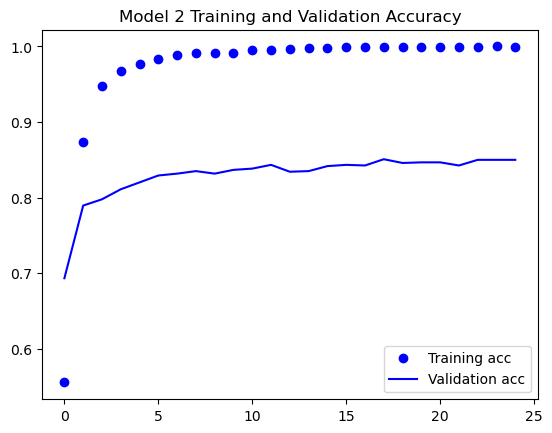

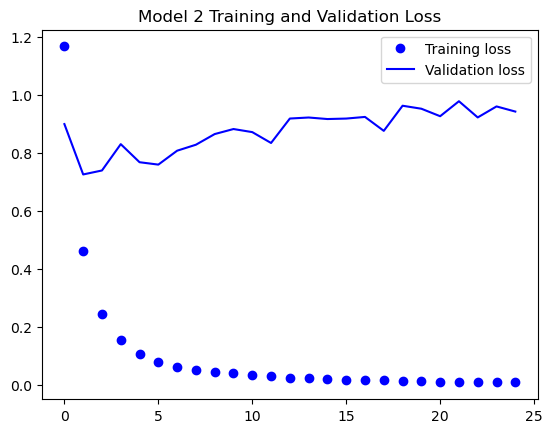

In [327]:
# Plot history
model_2_acc = model_2_histoire.history['accuracy']
model_2_val_acc = model_2_histoire.history['val_accuracy']
model_2_loss = model_2_histoire.history['loss']
model_2_val_loss = model_2_histoire.history['val_loss']
model_2_epochs = range(len(model_2_acc))

plt.plot(model_2_epochs, model_2_acc, 'bo', label = 'Training acc')
plt.plot(model_2_epochs, model_2_val_acc, 'b', label = 'Validation acc')
plt.title('Model 2 Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(model_2_epochs, model_2_loss, 'bo', label = 'Training loss')
plt.plot(model_2_epochs, model_2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.show();

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-09 00:07:37.495461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


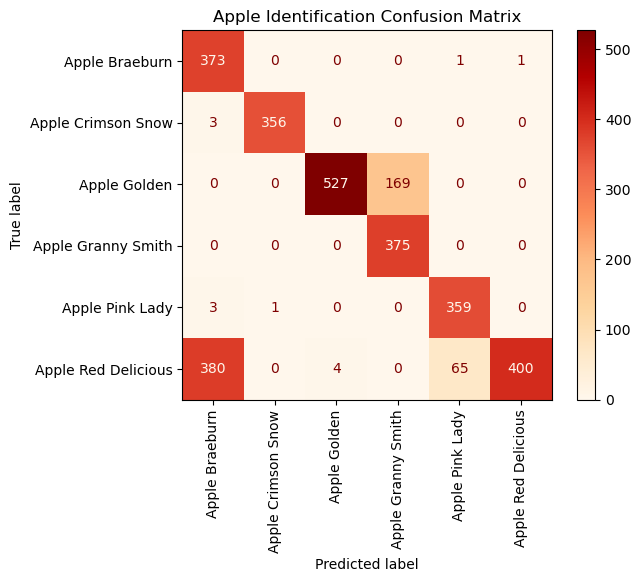

In [328]:
classifier = estimator(model_2, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = model_2_test_images, 
                      y_true = np.argmax(model_2_test_labels, axis = -1),
                      display_labels = class_names,
                      xticks_rotation = 'vertical',
                     cmap='OrRd');
plt.title('Apple Identification Confusion Matrix')
plt.show()

#### Model 3

In [329]:
model_3_train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range=10, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   channel_shift_range=10.)

model_3_test_datagen = ImageDataGenerator(rescale = 1./255)
model_3_val_datagen = ImageDataGenerator(rescale = 1./255)

In [330]:
model_3_image_size = (100, 100)
model_3_train_generator = model_3_train_datagen.flow_from_directory(
    aug_train_path,
    target_size = model_3_image_size,
    batch_size = 7841,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_3_test_generator = model_3_test_datagen.flow_from_directory(
    aug_test_path,
    target_size = model_3_image_size,
    batch_size = 3017,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_3_val_generator = model_3_val_datagen.flow_from_directory(
    aug_val_path,
    target_size = model_3_image_size,
    batch_size = 1207,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

Found 7841 images belonging to 6 classes.
Found 3017 images belonging to 6 classes.
Found 1207 images belonging to 6 classes.


In [331]:
def augment_images(apple_name):
    names = [os.path.join(f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}/'
                      , name) for name in os.listdir(f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}/')]
    for f in names:
        if f.endswith('.jpg'):
            img = Image.open(f)
            x = img_to_array(img) 
            # Reshape the input image 
            x = x.reshape((1, ) + x.shape)  
            i = 0

            # generate 2 new augmented images 
            for batch in model_3_train_datagen.flow(x, batch_size = 1, 
                              save_to_dir = f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}',  
                              save_prefix = 'aug-image-', save_format ='jpg'):
                i += 1
                if i > 2: 
                    break

In [332]:
# DO NOT RUN
# augment_images('Apple Braeburn')
# augment_images('Apple Crimson Snow')
# augment_images('Apple Golden')
# augment_images('Apple Granny Smith')
# augment_images('Apple Pink Lady')
# augment_images('Apple Red Delicious')

In [333]:
# create the data sets
model_3_train_images, model_3_train_labels = next(model_3_train_generator)
model_3_test_images, model_3_test_labels = next(model_3_test_generator)
model_3_val_images, model_3_val_labels = next(model_3_val_generator)

In [334]:
#Instantiate a Regularizer
reg = l2(3e-3)

model_3 = models.Sequential()
model_3.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
model_3.add(layers.Dropout(0.3))
model_3.add(layers.Conv2D(36, (3,3), activation='relu')) # 2 hidden layers
model_3.add(layers.Dropout(0.25))
model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
model_3.add(layers.Dropout(0.2))
#model_3.add(BatchNormalization())
model_3.add(layers.Flatten())
model_3.add(layers.Dense(24, activation = 'relu', kernel_regularizer = reg))
model_3.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
model_3.add(layers.Dense(24, activation='relu', kernel_regularizer = reg))
model_3.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))

In [335]:
opt = Adam(learning_rate=0.0002)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 1e-8, patience = 10)


np.random.seed(42)
model_3.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model_3_histoire = model_3.fit(model_3_train_images,
                                       model_3_train_labels,
                                       callbacks = [es],
                                       epochs = 70,
                                       batch_size = 120,
                                       validation_data = (model_3_val_images, model_3_val_labels))

Epoch 1/70


2022-12-09 00:07:51.448093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 1.9039 - accuracy: 0.3595

2022-12-09 00:07:55.839695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 5s 65ms/step - loss: 1.9039 - accuracy: 0.3595 - val_loss: 1.7026 - val_accuracy: 0.4888
Epoch 2/70
66/66 [==============================] - 4s 55ms/step - loss: 1.2358 - accuracy: 0.6222 - val_loss: 1.4538 - val_accuracy: 0.5443
Epoch 3/70
66/66 [==============================] - 4s 56ms/step - loss: 0.8700 - accuracy: 0.7512 - val_loss: 1.2628 - val_accuracy: 0.6023
Epoch 4/70
66/66 [==============================] - 4s 58ms/step - loss: 0.7106 - accuracy: 0.8097 - val_loss: 1.2543 - val_accuracy: 0.6156
Epoch 5/70
66/66 [==============================] - 4s 54ms/step - loss: 0.6096 - accuracy: 0.8392 - val_loss: 1.1876 - val_accuracy: 0.6645
Epoch 6/70
66/66 [==============================] - 4s 54ms/step - loss: 0.5417 - accuracy: 0.8651 - val_loss: 1.2379 - val_accuracy: 0.6736
Epoch 7/70
66/66 [==============================] - 4s 56ms/step - loss: 0.4895 - accuracy: 0.8875 - val_loss: 1.3283 - val_accuracy: 0.6645
Epoch 8/70
66/66 [======

In [336]:
model_3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 98, 98, 18)        504       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 49, 49, 18)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 49, 49, 18)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 47, 47, 36)        5868      
                                                                 
 dropout_16 (Dropout)        (None, 47, 47, 36)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 36)       0         
 g2D)                                                

In [337]:
model_3_results_train = model_3.evaluate(model_3_train_images, model_3_train_labels)
model_3_results_test = model_3.evaluate(model_3_test_images, model_3_test_labels)

95/95 [==============================] - 1s 15ms/step - loss: 1.4862 - accuracy: 0.8061


In [338]:
print(f'Model 3 Train Results: {model_3_results_train}')
print(f'Model 3 Test Results: {model_3_results_test}')

Model 3 Train Results: [0.29144105315208435, 0.9520469903945923]
Model 3 Test Results: [1.486237645149231, 0.8060987591743469]


In [339]:
#model_3.save('./Supplement Notebooks/Saved Models/Model 3', save_format='tf')
model_3_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 3')

In [340]:
model_3_saved.evaluate(model_3_train_images, model_3_train_labels)
model_3_saved.evaluate(model_3_test_images, model_3_test_labels)

  1/246 [..............................] - ETA: 42s - loss: 0.2344 - accuracy: 0.9688

2022-12-09 00:09:29.967766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 14ms/step - loss: 1.6850 - accuracy: 0.8041


[1.6850379705429077, 0.804110050201416]

#### Model 3 Visualizations

#### Graphing Accuracy and Loss Metrics

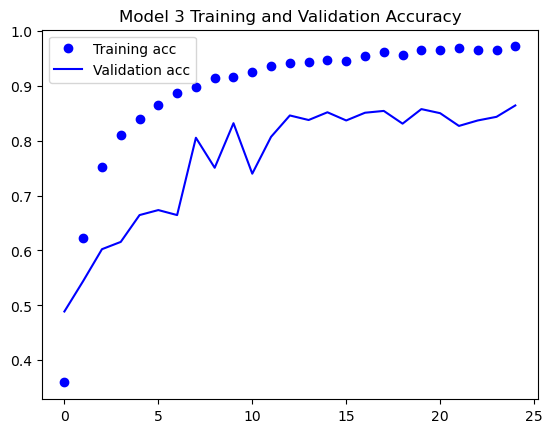

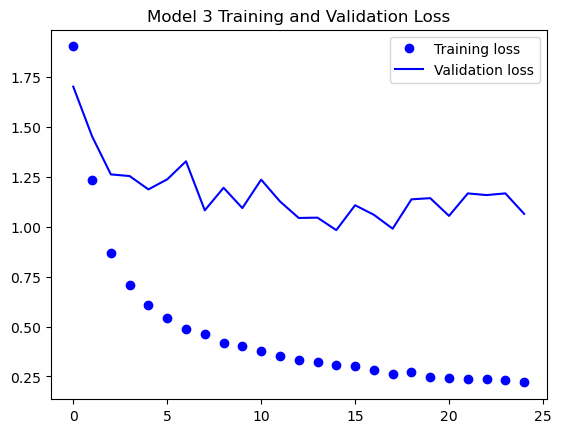

In [341]:
# Plot history
model_3_acc = model_3_histoire.history['accuracy']
model_3_val_acc = model_3_histoire.history['val_accuracy']
model_3_loss = model_3_histoire.history['loss']
model_3_val_loss = model_3_histoire.history['val_loss']
model_3_epochs = range(len(model_3_acc))

plt.plot(model_3_epochs, model_3_acc, 'bo', label = 'Training acc')
plt.plot(model_3_epochs, model_3_val_acc, 'b', label = 'Validation acc')
plt.title('Model 3 Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(model_3_epochs, model_3_loss, 'bo', label = 'Training loss')
plt.plot(model_3_epochs, model_3_val_loss, 'b', label = 'Validation loss')
plt.title('Model 3 Training and Validation Loss')
plt.legend()
plt.show();



#### Confusion Matrix

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-09 00:09:35.123747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


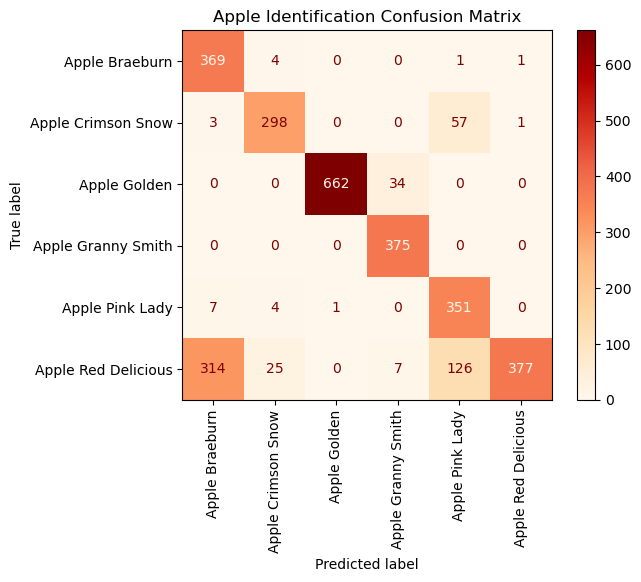

In [342]:
classifier = estimator(model_3, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = model_3_test_images, 
                      y_true = np.argmax(model_3_test_labels, axis = -1),
                      display_labels = class_names,
                      xticks_rotation = 'vertical',
                     cmap='OrRd');
plt.title('Apple Identification Confusion Matrix')
plt.show()